# Lab 1

# Implemented the model from the article [Attention is All You Need](https://arxiv.org/abs/1706.03762)

I did't achieve good accuracy. Colab blocked the GPU, I didn’t have time to find out precision.

One issue:

CUDA out of memory - decreased batch_size

## Part 2: Neural Machine Translation in the wild
Task: to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)
!wget -nc https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/datasets/Machine_translation_EN_RU/data.txt

--2022-06-14 09:49:38--  https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/datasets/Machine_translation_EN_RU/data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905334 (12M) [text/plain]
Saving to: ‘data.txt’

data.txt            100%[===================>]  12.31M  --.-KB/s    in 0.06s   

2022-06-14 09:49:39 (198 MB/s) - ‘data.txt’ saved [12905334/12905334]



The `data.txt` is a tsv file, each line of which contains a sentence in english and a corresponding translation, separated by `\t`. We'll load it into memory and create a list of pairs, which would yield the same interface as with the torchtext's datasets.

In [2]:
with open("data.txt") as f:
    data = [l.rstrip().split("\t") for l in f]

print(f"Dataset size {len(data):,}")
print("Sample:")
data[:5]

Dataset size 50,000
Sample:


[['Cordelia Hotel is situated in Tbilisi, a 3-minute walk away from Saint Trinity Church.',
  'Отель Cordelia расположен в Тбилиси, в 3 минутах ходьбы от Свято-Троицкого собора.'],
 ['At Tupirmarka Lodge you will find a 24-hour front desk, room service, and a snack bar.',
  'В числе удобств лоджа Tupirmarka круглосуточная стойка регистрации и снэк-бар. Гости могут воспользоваться услугой доставки еды и напитков в номер.'],
 ['Featuring free WiFi in all areas, Naigao Xiaowo offers accommodation in Shanghai.',
  'Апартаменты Naigao Xiaowo расположены в городе Шанхай. К услугам гостей бесплатный Wi-Fi во всех зонах.'],
 ['Each has a TV and a private bathroom with shower.',
  'В вашем распоряжении также телевизор и собственная ванная комната с душем.'],
 ['Your room comes with air conditioning and satellite TV.',
  'Номер оснащен кондиционером и спутниковым телевидением.']]

## Data preprocessing

First of all, let's split our dataset into train, test and validation.

In [3]:
import torch
from torch.utils.data import random_split


data_size = len(data)
train_size = int(0.8 * data_size)
test_size = int(0.15 * data_size)
val_size = data_size - train_size - test_size
train_data, test_data, val_data = random_split(
    data, [train_size, test_size, val_size], generator=torch.Generator().manual_seed(42)
)
print(f"Train size: {len(train_data)}")
print(f"Test size: {len(test_data)}")
print(f"Val size: {len(val_data)}")

Train size: 40000
Test size: 7500
Val size: 2500


Here comes the preprocessing. If you find pieces, that you don't understand, please, go back to 3rd week's practice notebook. The code is mostly taken from it.

Do not hesitate to use BPE or more complex preprocessing pipeline ;)

In [4]:
from nltk.tokenize import WordPunctTokenizer


tokenizer = WordPunctTokenizer()


def tokenize(sent):
    return tokenizer.tokenize(sent.lower())

In [5]:
from collections import Counter

from torchtext.vocab import vocab as Vocab


src_counter = Counter()
trg_counter = Counter()
for src, trg in train_data:
    src_counter.update(tokenize(src))
    trg_counter.update(tokenize(trg))

src_vocab = Vocab(src_counter, min_freq=3)
trg_vocab = Vocab(trg_counter, min_freq=3)

In [6]:
unk_token = "<unk>"
sos_token, eos_token, pad_token = "<sos>", "<eos>", "<pad>"
specials = [sos_token, eos_token, pad_token]

for vocab in [src_vocab, trg_vocab]:
    if unk_token not in vocab:
        vocab.insert_token(unk_token, index=0)
        vocab.set_default_index(0)

    for token in specials:
        if token not in vocab:
            vocab.append_token(token)

print(f"Source (en) vocabulary size: {len(src_vocab)}")
print(f"Target (ru) vocabulary size: {len(trg_vocab)}")

Source (en) vocabulary size: 6711
Target (ru) vocabulary size: 9310


In [7]:
def encode(sent, vocab):
    tokenized = [sos_token] + tokenize(sent) + [eos_token]
    return [vocab[tok] for tok in tokenized]

In [8]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader


def collate_batch(batch):
    src_list, trg_list = [], []
    for src, trg in batch:
        src_encoded = encode(src, src_vocab)
        src_list.append(torch.tensor(src_encoded))

        trg_encoded = encode(trg, trg_vocab)
        trg_list.append(torch.tensor(trg_encoded))

    src_padded = pad_sequence(src_list, padding_value=src_vocab[pad_token])
    trg_padded = pad_sequence(trg_list, padding_value=trg_vocab[pad_token])
    return src_padded, trg_padded


batch_size = 64
train_dataloader = DataLoader(train_data, batch_size, shuffle=True, collate_fn=collate_batch)
val_dataloader = DataLoader(val_data, batch_size, shuffle=False, collate_fn=collate_batch)
test_dataloader = DataLoader(test_data, batch_size, shuffle=False, collate_fn=collate_batch)

src_batch, trg_batch = next(iter(train_dataloader))
src_batch.shape, trg_batch.shape

(torch.Size([49, 64]), torch.Size([43, 64]))

## Layer


In [9]:
import random
import torch.nn as nn
from torch.nn.functional import relu

In [10]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        #x = [batch size, seq len, hid dim]
        x = self.dropout(self.relu(self.fc_1(x)))
        #x = [batch size, seq len, pf dim]
        x = self.dropout(self.fc_2(x))
        #x = [batch size, seq len, hid dim]
        return x

## Encoder

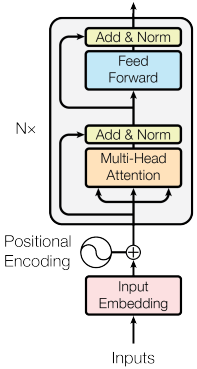

In [11]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout,
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = nn.MultiheadAttention(hid_dim, n_heads, dropout, device=device, batch_first=True)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        
    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, src len]    
        #1) self attention
        tmp, _ = self.self_attention(src, src, src, src_mask)
        #1.1) residual connection and layer norm (ADD & NORM)
        src = self.self_attn_layer_norm(src + tmp)
        #src = [batch size, src len, hid dim]

        #2) positionwise feedforward
        tmp = self.positionwise_feedforward(tmp)
        #2.1) residual and layer norm (ADD & NORM)
        src = self.ff_layer_norm(src + tmp)
        #src = [batch size, src len, hid dim]
        return src

In [12]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 200):
        super().__init__()
        
        self.device = device
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
        self.dropout = nn.Dropout(dropout)
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)

        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                          n_heads, 
                                          pf_dim,
                                          dropout, 
                                          device) 
                              for _ in range(n_layers)])
        
    def forward(self, src, src_mask):
        #src = [batch size, src len]
        #src_mask = [batch size, src len]
        batch_size = src.shape[0]
        src_len = src.shape[1]

        pos = torch.arange(0, src_len).unsqueeze(0)
        # dublicate for entire batch
        pos = pos.repeat(batch_size, 1).to(self.device)
        #pos = [batch size, src len]

        src = (self.tok_embedding(src) * self.scale) + self.pos_embedding(pos)
        src = self.dropout(src)
        #src = [batch size, src len, hid dim]

        for layer in self.layers:
            src = layer(src, src_mask)

        #src = [batch size, src len, hid dim]
        return src

## Decoder

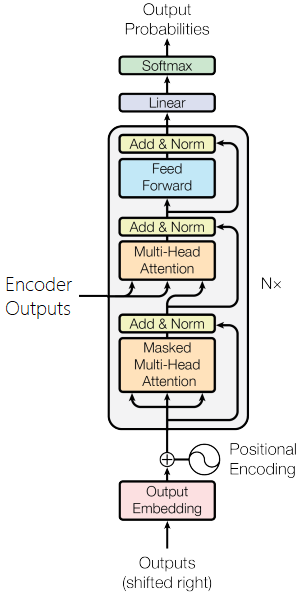

In [13]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention    = nn.MultiheadAttention(hid_dim, n_heads, dropout, device=device, batch_first=True)
        self.encoder_attention = nn.MultiheadAttention(hid_dim, n_heads, dropout, device=device, batch_first=True)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len, trg len]
        #src_mask = [batch size, src len]
        #1.1) self attention
        tmp, _ = self.self_attention(trg, trg, trg, attn_mask=trg_mask)
        #1.2) residual connection and layer norm (ADD & NORM)
        trg = self.self_attn_layer_norm(trg + tmp)
        #trg = [batch size, trg len, hid dim]
            
        #2) encoder attention
        tmp, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        #2.1) residual and layer norm (ADD & NORM)
        trg = self.enc_attn_layer_norm(trg + tmp) 
        #trg = [batch size, trg len, hid dim]
        
        #3) positionwise feedforward
        tmp = self.positionwise_feedforward(trg)
        #3.1) residual and layer norm (ADD & NORM)
        trg = self.ff_layer_norm(trg + tmp)

        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        return trg, attention

In [14]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 200):
        super().__init__()
        
        self.n_heads = n_heads
        self.device = device
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

        self.dropout = nn.Dropout(dropout)   
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)

    def forward(self, trg, enc_src, trg_mask, src_mask):
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        #print("DF ", trg.shape)
            
        #positional encoding
        pos = torch.arange(0, trg_len).unsqueeze(0)
        #dublicate for entire batch
        pos = pos.repeat(batch_size, 1).to(self.device)                            
        #pos = [batch size, trg len]
        trg = (self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos)
        trg = self.dropout(trg)
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        output = self.fc_out(trg)
        #output = [batch size, trg len, output dim]   
        #print(output)
        return output, attention

## Seq2Seq

In [15]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):
        #src = [batch size, src len]
        src_mask = (src == self.src_pad_idx)
        #src_mask = [batch size, src len]
        return src_mask
    
    def make_trg_mask(self, trg):
        #trg = [batch size, trg len]
        #print("trg", trg.shape)
        trg_pad_mask = (trg == self.trg_pad_idx).unsqueeze(1)
        #trg_pad_mask = [batch size, 1, trg len]
        #dublicate for each head
        trg_pad_mask = trg_pad_mask.repeat(self.decoder.n_heads, 1, 1)

        trg_len = trg.shape[1]
        #lower triangular part of the matrix
        trg_sub_mask = ~torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #print(trg_pad_mask.shape, trg_sub_mask.shape)
        #trg_sub_mask = [trg len, trg len]
        #print("trg_sub_mask", trg_sub_mask.shape, trg_sub_mask)
        #print("trg_pad_mask", trg_pad_mask.shape, trg_pad_mask)
        trg_mask = trg_pad_mask | trg_sub_mask
        #print("trg_mask", trg_mask.shape, trg_mask)
        #trg_mask = [batch size, trg len, trg len]
        return trg_mask

    def forward(self, src, trg):
        #TODO: add teacher_forcing_ratio
        #src = [batch size, src len]
        #trg = [batch size, trg len]

        src_mask = self.make_src_mask(src)
        #src_mask = [batch size, src len]
        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]
        #print(enc_src)
        
        trg_mask = self.make_trg_mask(trg)
        #trg_mask = [batch size, trg len, trg len]
        output, _ = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #print(output)
        #output = [batch size, trg len, output dim]
        return output

## Train model

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
INPUT_DIM = len(src_vocab)
OUTPUT_DIM = len(trg_vocab)
HID_DIM = 64
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 4
DEC_HEADS = 4
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [17]:
SRC_PAD_IDX = src_vocab[pad_token]
TRG_PAD_IDX = trg_vocab[pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [18]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)

model.apply(init_weights);

In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 2,204,446 trainable parameters


In [20]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=trg_vocab[pad_token])
loss_history, train_loss_history, val_loss_history = [], [], []

In [21]:
#torch.autograd.set_detect_anomaly(True)

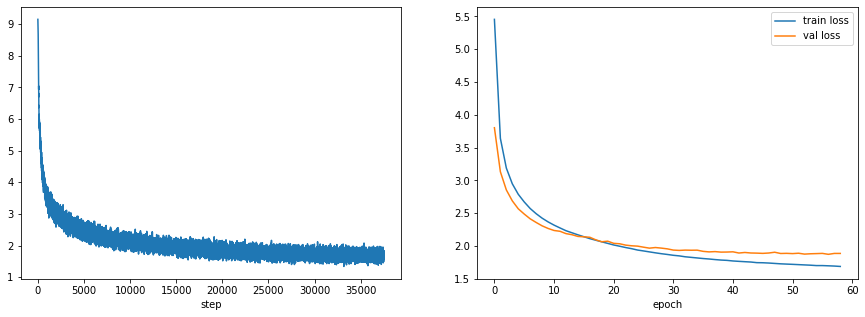

In [22]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.nn.utils import clip_grad_norm_


# Please don't use tensorboard here.
# It doesn't save the training plots in the notebook.
n_epochs = 60
clip = 1
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for src, trg in train_dataloader:
        src, trg = src.to(device).T, trg.to(device).T
        #print("1)", src[-1], trg[-1])
        #src = [batch size, src len] 
        #trg = [batch size, trg len])
        output = model(src, trg[:,:-1])
        #print(output)
        #print(output.shape, trg.shape)
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
        #torch.Size([55, 256, 9310]) torch.Size([56, 256])

        output = output.view(-1, output.shape[-1])
        #trg = trg[1:].view(-1)
        trg = trg[:,1:].contiguous().view(-1)

        #1) torch.Size([49, 256]) torch.Size([48, 256])
        #2) torch.Size([12032, 9310]) torch.Size([12032])

        #1) torch.Size([64, 54]) torch.Size([64, 46])
        #2) torch.Size([2880, 9310]) torch.Size([2880])
        #print("2)", output.shape, trg.shape)
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
        loss = criterion(output, trg)
        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        train_loss += loss.item()
        loss_history.append(loss.item())

        if len(loss_history) % 10 == 0:
            clear_output(wait=True)

            plt.figure(figsize=(15, 5))

            plt.subplot(121)
            plt.plot(loss_history)
            plt.xlabel("step")

            plt.subplot(122)
            plt.plot(train_loss_history, label="train loss")
            plt.plot(val_loss_history, label="val loss")
            plt.xlabel("epoch")
            plt.legend()

            plt.show()

    train_loss /= len(train_dataloader)
    train_loss_history.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for src, trg in val_dataloader:
            src, trg = src.to(device).T, trg.to(device).T
            output = model(src, trg[:,:-1])

            output = output.view(-1, output.shape[-1])
            #trg = trg[1:].view(-1)
            trg = trg[:,1:].contiguous().view(-1)

            loss = criterion(output, trg)

            val_loss += loss.item()

    val_loss /= len(val_dataloader)
    val_loss_history.append(val_loss)

## Model evaluation

In [23]:
trg_itos = trg_vocab.get_itos()
model.eval()
max_len = 50
with torch.no_grad():
    for i, (src, trg) in enumerate(val_data):
        encoded = encode(src, src_vocab)[::-1]
        #encoded = torch.tensor(encoded)[:, None].to(device)
        encoded = torch.tensor(encoded).unsqueeze(0).to(device)
        
        src_mask = model.make_src_mask(encoded)
        #hidden = model.encoder(encoded)
        enc_src = model.encoder(encoded, src_mask)

        pred_tokens = [trg_vocab[sos_token]]
        for _ in range(max_len):
            decoder_input = torch.tensor(pred_tokens).unsqueeze(0).to(device)
            #print(decoder_input)
            #trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
            #pred, hidden = model.decoder(decoder_input, hidden)  
            trg_mask = model.make_trg_mask(decoder_input)
            output, attention = model.decoder(decoder_input, enc_src, trg_mask, src_mask)
            #print("out", output)
            #_, pred_token = output[0].max(dim=1)
            pred_token = output.argmax(2)[:,-1]
            if pred_token == trg_vocab[eos_token]:
                # Don't add it to prediction for cleaner output.
                break

            pred_tokens.append(pred_token.item())

        print(f"src: '{src.rstrip().lower()}'")
        print(f"trg: '{trg.rstrip().lower()}'")
        print(f"pred: '{' '.join(trg_itos[i] for i in pred_tokens[1:])}'")
        print()

        if i == 10:
            break

All apartments have a DVD player and satellite TV, a kitchen with a microwave, and a washing machine and a tumble dryer. Все они оснащены телевизором со спутниковыми каналами и DVD-плеером, а также располагают кухней с микроволновой печью и стиральной/сушильной машиной.
enc tensor([[[ 1.7967e-02, -1.7519e-03, -7.1749e-02,  ...,  1.3178e-02,
          -5.2171e-02, -1.7046e-03],
         [ 1.6175e-02, -2.7664e-04, -1.0691e-01,  ..., -7.9947e-02,
          -2.3766e-02,  1.4827e-02],
         [ 2.9226e-03, -7.2348e-04, -8.2792e-02,  ..., -6.0948e-02,
          -8.0127e-03,  1.1452e-02],
         ...,
         [ 1.9976e-02, -2.3646e-04,  4.3960e-03,  ...,  3.1233e-02,
          -1.8332e-02,  1.5985e-02],
         [ 3.1385e-02, -1.7335e-03,  6.5625e-02,  ...,  4.9980e-02,
          -6.5720e-02,  5.4900e-05],
         [ 1.2878e-02, -2.9414e-03, -4.5319e-03,  ...,  1.2213e-01,
          -6.2682e-02, -1.5354e-02]]], device='cuda:0')
src: 'all apartments have a dvd player and satellite tv, a kit

The metric often used in NMT is the BLEU. We'll also use it to evaluate our models. In fact, the goal of this homework is to beat the specified baseline BLEU scores.

Here is how you can calculate the score for your model:

In [24]:
from nltk.translate.bleu_score import corpus_bleu


references, hypotheses = [], []
with torch.no_grad():
    for src, trg in test_dataloader:
        src = src.to(device).T
        trg = trg.to(device).T
        output = model(src, trg[:,:-1])
        #print(trg.shape)
        #torch.Size([72, 256, 9310])
        #torch.Size([48, 256, 9310])
        #output = [btach size, trg len, dict len]
        output = output.cpu().numpy().argmax(axis=2)
        #output = [btach size, trg len]

        for i in range(trg.shape[0]):
            reference = trg[i, :]
            reference_tokens = [trg_itos[id_] for id_ in reference]
            reference_tokens = [tok for tok in reference_tokens if tok not in specials]
            references.append(reference_tokens)

            hypothesis = output[i, :]
            hypothesis_tokens = [trg_itos[id_] for id_ in hypothesis]
            hypothesis_tokens = [tok for tok in hypothesis_tokens if tok not in specials]
            hypotheses.append(hypothesis_tokens)

# corpus_bleu works with multiple references
bleu = corpus_bleu([[ref] for ref in references], hypotheses)
print(f"Your model shows test BLEU of {100 * bleu:.1f}")

Your model shows test BLEU of 12.0


Baseline solution BLEU score is quite low. Try to achieve at least __24__ BLEU on the test set. 
The checkpoints are:

* __22__ - minimal score to submit the homework, 30% of points

* __27__ - good score, 70% of points

* __29__ - excellent score, 100% of points

# **Выводы и рабочие моменты**
Реализована модель как в статье  [Attention is All You Need](https://arxiv.org/abs/1706.03762)

Убил море времени. Колаб заблочил мне GPU, качество узнать не успел.

CUDA out of memory - уменьшил batch_size

## ATTEMPT TO USE BERT (NOT USED)

In [ ]:
!pip install transformers

ERROR: Operation cancelled by user


In [ ]:
import transformers as ppb
# For DistilBERT:
# model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

ModuleNotFoundError: ignored

In [ ]:
model